In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import sys
if '..' not in sys.path:
    sys.path.append('..')

from matplotlib import pyplot as plt
import numpy as np
import open3d as o3d

from sdp.ds.bop_data import BopModelsInfo, read_models_info, id_to_str, read_meshes
from sdp.ds.bop_dataset import BopDataset


In [3]:
DATA_PATH = Path(os.path.expandvars('$HOME/data'))
BOP_PATH = DATA_PATH / 'bop'
ITODD_SUBDIR = 'itodd'
ITODD_BOP_PATH = BOP_PATH / ITODD_SUBDIR
ITODD_MODELS_PATH = ITODD_BOP_PATH / 'models'
print(f'BOP path: {BOP_PATH}')

BOP path: /Users/misha/data/bop


In [4]:
obj_id = 1
out_size = 256

In [5]:
ds = BopDataset.from_dir(BOP_PATH, ITODD_SUBDIR)

Reading dataset from /Users/misha/data/bop/itodd/.sdp/v0.0.1


In [6]:
models_info = read_models_info(ITODD_MODELS_PATH / 'models_info.json')
models_info[obj_id]

BopModelInfo(model_id=1, diameter=64.0944, pt_min=array([-25.5  , -22.639, -10.759]), pt_max=array([25.5  , 22.639, 10.759]), size=array([51.   , 45.278, 21.518]), syms_discrete=[], syms_continuous=[])

In [7]:
model_info = models_info[obj_id]
meshes = read_meshes(ITODD_MODELS_PATH, obj_id)
mesh = meshes[obj_id]
m3d = mesh.mesh_o3d
m3d.compute_vertex_normals()
m3d.paint_uniform_color((0.5, 0, 0))

TriangleMesh with 657 points and 1338 triangles.

In [8]:
objs_view = ds.get_objs_view(obj_id, out_size=out_size)

min_mask_ratio: 20671 --> 18066
min_bbox_dim_ratio: 18066 --> 16071


In [9]:
gt = objs_view.get_gt_imgs_masks(0)

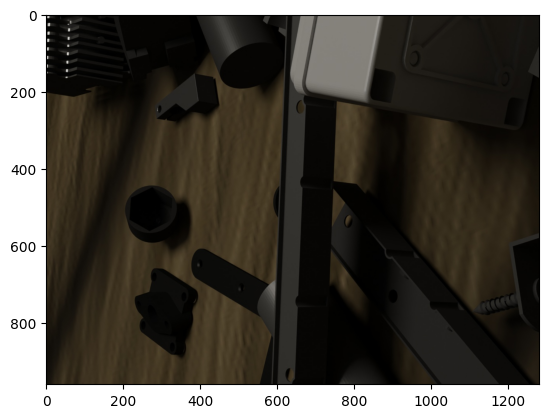

In [10]:
plt.imshow(gt.imgs[0])

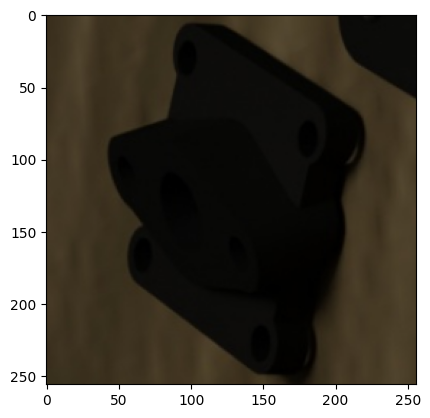

In [11]:
plt.imshow(gt.imgs_crop[0])

In [12]:
dfi = gt.df_img
dfi

,scene_id,img_id,cam_depth_scale,img_width,img_height,cam_K
img_ds_id,,,,,,
736,0,736,0.1,1280,960,"[[2992.14, 0.0, 633.4119874238968], [0.0, 3003..."


In [13]:
dfo = gt.df_obj
dfo

,img_ds_id,obj_ind,obj_id,px_count_all,px_count_valid,px_count_visib,visib_fract,R_m2c,t_m2c,bbox_obj_ltwh,bbox_visib_ltwh
obj_ds_id,,,,,,,,,,,
18356,736,6,1,23189,23189,23187,0.999914,"[[0.5743472576141357, -0.04910771921277046, -0...","[-82.41505432128906, 72.3970718383789, 772.482...","[230.0, 660.0, 159.0, 225.0]","[230.0, 660.0, 159.0, 225.0]"


In [14]:
ri, ro = dfi.iloc[0], dfo.iloc[0]
cam_int = o3d.camera.PinholeCameraIntrinsic(ri['img_width'], ri['img_height'], ri['cam_K'])
cam_int

PinholeCameraIntrinsic with width = 1280 and height = 960.
Access intrinsics with intrinsic_matrix.

In [15]:
width, height = ri['img_width'], ri['img_height']
K = ri['cam_K']
fx, fy = K[0, 0], K[1, 1]
cx, cy = K[0, 2], K[1, 2]
t_m2c, R_m2c = ro['t_m2c'] * mesh.mul_to_meters, ro['R_m2c']


In [ ]:
cam_int = o3d.camera.PinholeCameraIntrinsic(width, height, K)
cam_ext = np.eye(4)
vis = o3d.visualization.Visualizer()
vis.create_window(width=width, height=height, left=200, top=200)
# m3d.rotate(ro['R_m2c'])
# m3d.translate(ro['t_m2c'])
tr = np.eye(4)
tr[:3, :3] = R_m2c
tr[:3, 3] = t_m2c
print(f'Transform:\n{tr}')
m3d.transform(tr)
vis.add_geometry(m3d)
ctr = vis.get_view_control()
cam_param = ctr.convert_to_pinhole_camera_parameters()
# cam_param.intrinsic.set_intrinsics(width, height, fx, fy, cx, cy)
cam_param.intrinsic = cam_int
cam_param.extrinsic = cam_ext
ctr.convert_from_pinhole_camera_parameters(cam_param, allow_arbitrary=True)
vis.run()
# vis.destroy_window()
# vis.update_geometry()
# vis.poll_events()
# vis.update_renderer()
img_o3d = vis.capture_screen_float_buffer(True)
vis.destroy_window()
print(img_o3d)
img = np.asarray((img_o3d))
print(img.dtype, img.shape)
plt.imshow(img)

In [41]:
np.asarray(m3d.vertices)

array([[-88.27695464,  52.41747293, 793.12311741],
       [-87.77526179,  53.41500139, 792.34528935],
       [-92.48318844,  52.90931059, 788.66021664],
       ...,
       [-78.32188399,  94.82118509, 768.07313189],
       [-93.82925994,  87.42171204, 788.90025851],
       [-92.89593577,  83.58965554, 788.23373484]])

In [5]:
obj_path = DATA_PATH / 'sds_data' / 'objs' / 'teamug.stl'
mesh = o3d.io.read_triangle_mesh(str(obj_path), True)

In [6]:
mesh.compute_triangle_normals()
mesh.compute_vertex_normals()
mesh.vertices, mesh.triangles, mesh.vertex_normals, mesh.triangle_normals

(std::vector<Eigen::Vector3d> with 129251 elements.
 Use numpy.asarray() to access data.,
 std::vector<Eigen::Vector3i> with 59328 elements.
 Use numpy.asarray() to access data.,
 std::vector<Eigen::Vector3d> with 129251 elements.
 Use numpy.asarray() to access data.,
 std::vector<Eigen::Vector3d> with 59328 elements.
 Use numpy.asarray() to access data.)

In [7]:
vs, ts = np.asarray(mesh.vertices), np.asarray(mesh.triangles)
print(vs.shape, vs.dtype, vs.min(), vs.mean(), vs.max())
print(ts.shape, ts.dtype, ts.min(), ts.mean(), ts.max())

(129251, 3) float64 -0.24444793164730072 -0.00841415762465798 0.2220826894044876
(59328, 3) int32 0 63898.17107155699 129250


In [8]:
norms = np.asarray(mesh.vertex_normals)
np.allclose(np.linalg.norm(norms, axis=1), 1)

True

In [9]:
models_path = ITODD_BOP_PATH / 'models'
models_info_path = models_path / 'models_info.json'
models_info = read_models_info(models_info_path)


In [10]:
models_info[1]

BopModelInfo(model_id=1, diameter=64.0944, pt_min=array([-25.5  , -22.639, -10.759]), pt_max=array([25.5  , 22.639, 10.759]), size=array([51.   , 45.278, 21.518]), syms_discrete=[], syms_continuous=[])

In [11]:
model_info = models_info[1]
model_fpath = models_path / f'obj_{id_to_str(model_info.model_id)}.ply'
print(f'Loading {model_fpath}')
mesh_o3d = o3d.io.read_triangle_mesh(str(model_fpath), True)
mesh_o3d

Loading /Users/misha/data/bop/itodd/models/obj_000001.ply


TriangleMesh with 657 points and 1338 triangles.

In [12]:
verts = np.asarray(mesh_o3d.vertices)
verts.min(), verts.mean(), verts.max()

(-25.5, 0.7481359236732621, 25.5)

In [14]:
o3d.visualization.draw_geometries([mesh])


In [24]:
m = gt.masks[0]
m.shape, m.dtype, m.min(), m.max()

((960, 1280), dtype('uint8'), 0, 7)

In [25]:
gt.bboxes_ltwh_src

[array([191, 654, 236, 236])]